In [11]:
import colorsys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

_width, _height = 10, 6
_res = 8

_field_shape =[int(_height*_res), int(_width*_res)]

_charges= [
    {
        "q":-1.0, 
        "p":np.array([-4.0,1.0]),
        "v":np.array([1.0,0.0]),
    },
    {
        "q":-1.0, 
        "p":np.array([0.0,-1.0]),
        "v":np.array([-1.0,0.0]),
    },
    {
        "q":1.0, 
        "p":np.array([4.0,0.0]),
        "v":np.array([0.0,0.0]),
    },
]
_num_charges = len(_charges)

_x,_y = np.meshgrid(
    np.linspace(-_width/2, _width/2, int(_width*_res)),
    np.linspace(-_height/2, _height/2, int(_height*_res)),    
)
# w = np.zeros(field_shape)

In [2]:

def calc_e_field(charges,x,y,index):
    c = charges[index]
    a = c["p"]
    q = c["q"]
    
    b_p = np.array([x,y])   
    a_p = np.array([np.full(x.shape,a[0]), np.full(x.shape,a[1])])
    dir = b_p-a_p
    mag_squared = dir[0]**2 + dir[1]**2
    mag = np.sqrt(mag_squared)

    f = q/mag_squared
    f_vec = f * dir/mag

    return f_vec[0], f_vec[1]

def calc_total_e_field(charges,x,y):
    u = np.zeros(_field_shape)
    v = np.zeros(_field_shape)
    for i in range(len(charges)):
        temp_u, temp_v = calc_e_field(charges,x,y,i)
        u+=temp_u
        v+=temp_v

    return u,v

def normalise(x,y):
    mag = np.sqrt(x**2 + y**2)
    return x/mag, y/mag, mag

def sigmoid(m):
    return 1/(1+np.power(np.e, -m))

def plot(ax,x,y,u,v,m):    
    # ax.view_init(30, 30)
    # ax.quiver(x,y,u,v,colors=colors,length=0.25,normalize=True,pivot="middle")
    ax.quiver(x,y,u,v, sigmoid(m))

def move_charges(charges, delta_time):
    for c in charges:
        c["p"] += c["v"] * delta_time

def apply_electric_force(charges, delta_time):
    c_indices = range(len(charges))
    for c_index in c_indices:
        c = charges[c_index]
        total_vel = np.zeros(c["p"].shape)
        for cur_index in c_indices:
            if c_index == cur_index:
                continue
            cur_c = charges[cur_index]
            dir = cur_c["p"] - c["p"]
            mag_squared = np.dot(dir, dir)
            mag = np.sqrt(mag_squared)
            dir_norm = dir/mag

            f = (c["q"]*cur_c["q"])/mag_squared
            total_vel += dir_norm * f
        c["v"] += total_vel*delta_time

In [9]:
def advance_time_step(charges, x,y,interval):
    if interval != 0:
        apply_electric_force(charges, interval)
        move_charges(charges, interval)

    u,v=calc_total_e_field(charges,x,y)
    return normalise(u,v)

def animate(frame_number,qr,charges,x,y):
    u,v,m = advance_time_step(charges,x,y,0.1)
    qr.set_UVC(u, v)
    colors = [colorsys.hls_to_rgb(h,0.9,0.9) for h in sigmoid(m.flatten())]
    qr.set_color(colors)
    return qr,

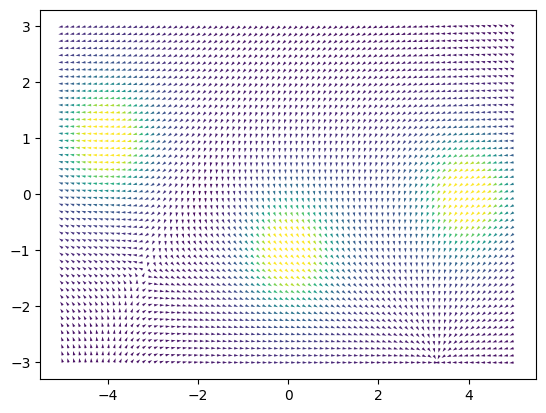

In [12]:
interval = 0.1
_u,_v,_m = advance_time_step(_charges,_x,_y,0)
fig, ax = plt.subplots(1, 1)
_qr = ax.quiver(_x, _y, _u, _v, sigmoid(_m))

anim = animation.FuncAnimation(fig, animate, fargs=(_qr,_charges,_x,_y), interval=50, blit=False)

FFwriter = animation.FFMpegWriter(fps=10)
anim.save('animations/animation.mp4', writer = FFwriter)